### Collaborative Filtering (Item Based)
We will be using movie lens dataset for trying out how item based collaborative filtering works. We will be using mulitple approaces

1. *Item Item filtering approach*
    * Item item filtering aims to find similar items on the basis of their ratings/clicks/views 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../rating.csv')
df.info()
df = df.drop('timestamp',axis = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    object
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [3]:
print(f'Unique users : {df.userId.nunique()} and unique movies : {df.movieId.nunique()}')

Unique users : 138493 and unique movies : 26744


Computing a 27K X 27K similarity matrix for user over 138K dimensional vector may prove to be computationally expensive, hence we will try to reduce the dataset and its sparsity by taking top users and movies

In [4]:
# Calculating cumulative percentages of ratings received at movie level
number_of_ratings = df.shape[0]

movieId_rating_count = df.movieId.value_counts().reset_index().rename(columns = {'index':'MovieId','movieId':'Cnt_Users_Rated'}).sort_values(by = 'Cnt_Users_Rated',ascending = False)
movieId_rating_count['Cumulative_Perc'] = movieId_rating_count.Cnt_Users_Rated.cumsum()/number_of_ratings

movieids_at_80 = movieId_rating_count.loc[movieId_rating_count['Cumulative_Perc'] <= 0.80,'MovieId']
print(f'Number of movies which received 80% of the total ratings : {len(movieids_at_80)} and is {round(len(movieids_at_80)*100/df.movieId.nunique(),2)}% of total movie base')

Number of movies which received 80% of the total ratings : 1948 and is 7.28% of total movie base


In [5]:
# Calculating cumulative percentages of ratings received at user level

userId_rating_count = df.userId.value_counts().reset_index().rename(columns = {'index':'UserId','userId':'Cnt_Movies_Rated'}).sort_values(by = 'Cnt_Movies_Rated',ascending = False)
userId_rating_count['Cumulative_Perc'] = userId_rating_count.Cnt_Movies_Rated.cumsum()/number_of_ratings

userids_at_80 = userId_rating_count.loc[userId_rating_count['Cumulative_Perc'] <= 0.4,'UserId']
print(f'Number of users who have given 40% of the total ratings : {len(userids_at_80)} and is {round(len(userids_at_80)*100/df.userId.nunique(),2)}% of total user base')

Number of users who have given 40% of the total ratings : 10691 and is 7.72% of total user base


In [6]:
# subsetting dataset for selected userids and movieids

df = df.loc[(df['userId'].isin(userids_at_80)) & (df['movieId'].isin(movieids_at_80))]
print(f'Number of ratings after using top 40% users and 80% movies : {df.shape[0]/number_of_ratings * 100 :.2f}%')

Number of ratings after using top 40% users and 80% movies : 27.85%


In [7]:
# Dividing in train and test
train, test = train_test_split(df, test_size = 0.2)

In [8]:
# Finding the average rating for each movie
avg_ratings_train = train.groupby('movieId').agg({'rating':'mean'}).reset_index().rename(columns = {'movieId':'movieId','rating':'avg_rating'})
avg_ratings_test = test.groupby('movieId').agg({'rating':'mean'}).reset_index().rename(columns = {'movieId':'movieId','rating':'avg_rating'})

train = pd.merge(train,avg_ratings_train, on = 'movieId', how = 'left')
train['avg_rating'] = train.avg_rating.round(5)
train['Deviations'] = train['rating'] - train['avg_rating']

test = pd.merge(test,avg_ratings_test, on = 'movieId', how = 'left')
test['avg_rating'] = test.avg_rating.round(5)
test['Deviations'] = test['rating'] - test['avg_rating']

In [9]:
train.head()

,userId,movieId,rating,avg_rating,Deviations
0,121535,1088,3.0,3.02889,-0.02889
1,35227,163,2.0,3.38790,-1.38790
2,46211,10,4.0,3.30948,0.69052
3,41496,3264,2.5,2.93756,-0.43756
4,13090,2302,3.0,3.55326,-0.55326


In [10]:
import time

t = time.process_time()
min_user_cnt = 5
movie_nn_weights = {}
nn = 50
counter = 0
train_id_len = len(train.movieId.unique())

for i in train.movieId.unique():
    u_id = set(train[train.movieId==i]['userId'].values)  ## all the users who have rated the movie i
    temp = train.loc[train.userId.isin(u_id)] ## all the movies rated by users who also rated movie i
    m_id = temp.groupby('movieId').agg({'userId':'count'}).reset_index().query('userId > @min_user_cnt').movieId.values
    
    temp = temp.loc[temp.movieId.isin(m_id)]
    temp = temp.pivot(index = 'userId',columns = 'movieId', values = 'rating')
    
    corr_df = temp.drop(i, axis = 1).apply(lambda x: round(x.corr(temp[i]),5)).reset_index().rename(columns = {'movieId':'movieId',0:'Corr'})
    corr_df['ab_corr'] = abs(corr_df['Corr'])
    #corr_df = corr_df.loc[corr_df.movieId!= i]
    corr_df = corr_df.sort_values(by = 'ab_corr',ascending = False).head(nn)

    movie_nn_weights[i] = tuple(zip(corr_df.movieId,corr_df.Corr))
    counter += 1
    if counter%200 == 0:
        print(f'Completed {counter*100/train_id_len:.2f}%')

Completed 10.27%
Completed 20.53%
Completed 30.80%
Completed 41.07%
Completed 51.33%
Completed 61.60%
Completed 71.87%
Completed 82.14%
Completed 92.40%


In [11]:
elapsed_time = time.process_time() - t
elapsed_time

4507.8125

In [12]:
import pickle
with open('movie_nn_weights_1948_50nn.json', 'wb') as f:
  pickle.dump(movie_nn_weights, f)

In [13]:
user_movie_index_train = {}

for i in train.userId.unique():
    user_movie_index_train[i] = train.index[train.userId==i]

In [14]:
user_movie_index_test = {}

for i in test.userId.unique():
    user_movie_index_test[i] = test.index[test.userId==i]

In [15]:
def predict_rating(j,u,data,user_movie_index, weights, nn,avg_ratings):

    nn_weights = {}
    for m,c in weights[j]:
        nn_weights[m] = c
    
    nn_weights = pd.DataFrame.from_dict(nn_weights,orient = 'index',columns = ['weight']).reset_index().rename(columns = {'index':'movieId','weight':'weight'})
    nn_weights = nn_weights.head(nn)
    ##uj_m = data.loc[data.movieId==m]
    mj_u = data.loc[user_movie_index[u]]
    mj_u = pd.merge(mj_u, nn_weights, on = 'movieId', how = 'inner')

    ####nn_uj_m = set(nn_m) & set(uj_m)

    moviej_avg_rating = avg_ratings[avg_ratings.movieId==j]['avg_rating'].values
    if len(mj_u):
        prediction = moviej_avg_rating + sum(mj_u.Deviations * mj_u.weight)/abs(mj_u.weight).sum()
    else:
        prediction = moviej_avg_rating
    
    return(prediction[0],len(mj_u))
    #return(nn_weights)

In [16]:
start = time.process_time()
print(predict_rating(1270,131896,train,user_movie_index_train,movie_nn_weights,45,avg_ratings_train))
time.process_time() - start

(4.105791211719914, 20)


0.28125

In [17]:
from IPython.display import clear_output
start = time.process_time()

train_mse = {}

for j in range(20,55,5):
    counter = 0
    pred_train = []
    nn_used_for_prediction = []
    for i, m in list(zip(train.movieId,train.userId)):
        p, n = predict_rating(i,m,train,user_movie_index_train,movie_nn_weights,j,avg_ratings_train)
        pred_train.append(p)
        nn_used_for_prediction.append(n)
        counter += 1
        if counter%1000000==0:
            print(f'Completed {counter*100/len(train):.2f}%')
    
    
    train['Predictions'] = pred_train
    train['nn'] = nn_used_for_prediction
    mse = ((train.rating - train.Predictions)**2).mean()
    train_mse[j] = mse
    print(f'Completed training mse for {j} neighbours and mse is {mse}')

time.process_time() - start

Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 20 neighbours and mse is 0.5926491899669095
Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 25 neighbours and mse is 0.5727833571449584
Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 30 neighbours and mse is 0.5581326957424197
Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 35 neighbours and mse is 0.547439182268991
Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 40 neighbours and mse is 0.5396853373112157
Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 45 neighbours and mse is 0.533618419068352
Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 50 neighbours and mse is 0.5290080976100414


151902.890625

In [18]:
from IPython.display import clear_output
start = time.process_time()

test_mse = {}

for j in range(20,55,5):
    counter = 0
    pred_test = []
    nn_used_for_prediction = []
    for i, m in list(zip(test.movieId,test.userId)):
        p, n = predict_rating(i,m,test,user_movie_index_test,movie_nn_weights,j,avg_ratings_test)
        pred_test.append(p)
        nn_used_for_prediction.append(n)
        counter += 1
        if counter%200000==0:
            print(f'Completed {counter*100/len(test):.2f}%')
    
    
    test['Predictions'] = pred_test
    test['nn'] = nn_used_for_prediction
    mse = ((test.rating - test.Predictions)**2).mean()
    test_mse[j] = mse
    print(f'Completed test mse for {j} neighbours and mse is {mse}')

time.process_time() - start

Completed 17.96%
Completed 35.91%
Completed 53.87%
Completed 71.82%
Completed 89.78%
Completed test mse for 20 neighbours and mse is 0.8267197277795809
Completed 17.96%
Completed 35.91%
Completed 53.87%
Completed 71.82%
Completed 89.78%
Completed test mse for 25 neighbours and mse is 0.8150524599661931
Completed 17.96%
Completed 35.91%
Completed 53.87%
Completed 71.82%
Completed 89.78%
Completed test mse for 30 neighbours and mse is 0.8021702011856923
Completed 17.96%
Completed 35.91%
Completed 53.87%
Completed 71.82%
Completed 89.78%
Completed test mse for 35 neighbours and mse is 0.7878170580161604
Completed 17.96%
Completed 35.91%
Completed 53.87%
Completed 71.82%
Completed 89.78%
Completed test mse for 40 neighbours and mse is 0.7745713685189974
Completed 17.96%
Completed 35.91%
Completed 53.87%
Completed 71.82%
Completed 89.78%
Completed test mse for 45 neighbours and mse is 0.7615432121858821
Completed 17.96%
Completed 35.91%
Completed 53.87%
Completed 71.82%
Completed 89.78%
Com

36490.09375

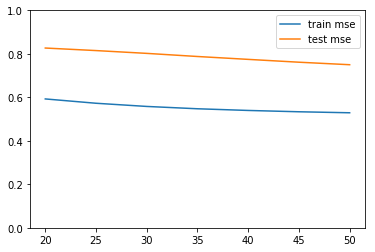

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = list(range(20,55,5))
plt.plot(x,train_mse.values(), label='train mse')
plt.plot(x,test_mse.values(), label='test mse')
plt.ylim([0, 1])
#plt.xticks(x, labels, rotation ='vertical')
plt.legend()
plt.show()

In [20]:
np.sqrt(train_mse[50]),np.sqrt(test_mse[50])

(0.727329428532932, 0.8660294817765746)

In the benchmark range of [0.83 - 0.86]

In [24]:
train['se'] = abs(train.rating - train.Predictions)
test['se'] = abs(test.rating - test.Predictions)

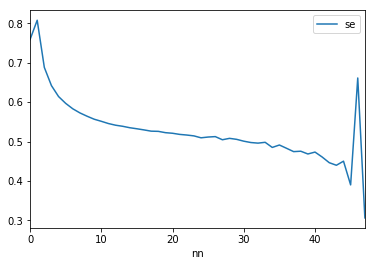

In [25]:
train.groupby('nn').agg({'se':'mean'}).plot()

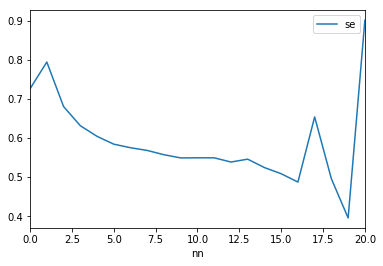

In [26]:
test.groupby('nn').agg({'se':'mean'}).plot()